In [3]:
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.optim as optim
from torchvision.transforms import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from DataSet import WaterTemperatureDataSet
import datetime

# Part I: 

Aggregating the data

In [4]:
root_dir = "Data/"

n_inputs = 1

Choisy = pd.read_csv(root_dir + "Choisy-le-roi.csv", sep=";", decimal=',')
Neuilly = pd.read_csv(root_dir + "Neuilly.csv", sep=';', decimal=",") 
Bougival = pd.read_csv(root_dir + "Bougival.csv", sep=";", decimal=",") # 1453
St_Maure = pd.read_csv(root_dir + "Historique-St-Maur.csv", sep=";", decimal=",")

In [5]:
Choisy

,Date,Temp,Min,Max,Origine,Site
0,17/02/1987,5.70,NaN,NaN,7,16
1,18/02/1987,5.50,NaN,NaN,7,16
2,19/02/1987,5.20,NaN,NaN,7,16
3,20/02/1987,4.60,NaN,NaN,7,16
4,21/02/1987,4.40,NaN,NaN,7,16
...,...,...,...,...,...,...
12463,27/01/2022,5.71,5.64,6.00,7,16
12464,28/01/2022,5.81,5.68,5.90,7,16
12465,29/01/2022,6.02,5.83,6.15,7,16
12466,30/01/2022,6.23,6.05,6.33,7,16


In [6]:
air_min = pd.read_csv(root_dir + "TMINJ.txt", sep="\s+")
air_max = pd.read_csv(root_dir + "TMAXJ.txt", sep="\s+")
air_avg = pd.read_csv(root_dir + "TMPH.txt", sep="\s+")

In [7]:
air_max["I_day"] = pd.to_datetime(air_max["I_day"] - 1, origin='01/01/1970', unit='d')
air_min["I_day"] = pd.to_datetime(air_min["I_day"] - 1, origin='01/01/1970', unit='d')
air_avg["I_Jour"] = pd.to_datetime(air_avg["I_Jour"] - 1, origin='01/01/1970', unit='d')

In [8]:
cols = air_avg.columns
avg_temp = air_avg.groupby("I_Jour")[cols].mean()

C:\Users\guill\AppData\Local\Temp\ipykernel_38428\468800075.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_temp = air_avg.groupby("I_Jour")[cols].mean()


In [9]:
air = pd.merge(air_min, air_max, on="I_day", suffixes=["_min", "_max"])

In [10]:
air = pd.merge(air, avg_temp, right_index=True, left_on="I_day")

In [22]:
def perform_data_augmentation(station, water_attribute="Temp", water_min="Min", water_max="Max"): 
    NATURAL = int(0)
    AUGMENTED = int(1)

    station["year"] = pd.DatetimeIndex(station["Date"]).year
    years = station["year"].unique()
    columns = station.columns

    augmented = pd.DataFrame(columns=columns)

    for year in years: 
        index = pd.date_range('01-01-' + str(year), '12-31-' + str(year))
        segment = station.loc[station["year"] == year, columns]
        segment["DataType"] = NATURAL

        first_date = segment["Date"].min()
        last_date = segment["Date"].max()   
        n_points = len(segment["year"]) 
     
        segment = segment.set_index("Date")
        segment = segment.reindex(index, fill_value= -1)

        segment["DataType"] = NATURAL
        segment.loc[segment[water_attribute] == -1, "DataType"] = AUGMENTED
        segment.loc[segment[water_attribute] == -1, [water_attribute, water_max, water_min]] = float('nan')

        if check_validity(segment, n_points, first_date, last_date):
            segment = augment(segment, first_date, last_date, water_attribute=water_attribute, water_min=water_min, water_max=water_max)
            augmented = pd.concat([augmented, segment.rename_axis('Date').reset_index()])

    return augmented

def check_validity(segment, n_points, first_date, last_date):
    date_check = (last_date.month != 12 or last_date.day < 28) or (first_date.month != 1 or first_date.day > 5)

    counter = segment.loc[(segment.index < last_date) & (segment.index > first_date), "DataType"].diff().ne(0).cumsum()
    hole_check = (counter.max() > 5)
    len_check = (len(segment) == 365)

    
    if date_check or hole_check:
        return False
    else: 
        return True

def augment(segment, first_date, last_date, water_attribute="Temp", water_min="Min", water_max="Max"):
    attributes = [water_max, water_min, water_attribute]

    for attribute in attributes: 
        below = segment[[attribute, "DataType"]].fillna(method='ffill')
        above = segment[[attribute, "DataType"]].fillna(method='bfill')

        below = below.loc[below["DataType"] == 1, [attribute]]
        above = above.loc[above["DataType"] == 1, [attribute]]

        mean = pd.merge(below, above, left_index=True, right_index=True).mean(axis=1, numeric_only=True, skipna=True)

        segment.loc[segment["DataType"] == 1, attribute] = mean

    if (len(segment) == 366): 
        year = last_date.year
        index = datetime.date(year=year, day=29, month=2)
        segment.drop(index=index, inplace=True)

    return segment


In [23]:
buffer = [Bougival, Neuilly, Choisy]
stations = []

for station in buffer: 
    station["Date"] = pd.to_datetime(station["Date"], format="%d/%m/%Y")
    station = perform_data_augmentation(station)
    stations.append(station)

In [24]:
air = air.set_index("I_day")

In [25]:
database = []
safran = [1453, 1565, 1680]
name = ["Bougival", "Neuilly", "Choisy"]

for i, station in enumerate(stations): 
    cols = [str(safran[i]), str(safran[i]) + "_min", str(safran[i]) + "_max"]
    append = pd.merge(station, air[cols], left_on="Date", right_index=True).rename(columns={cols[0]:"Air_Avg", cols[1]:"Air_Min", cols[2]:"Air_Max"})
    append["location"] = name[i]
    database.append(append)

In [26]:
main = pd.concat(database)
main.head(-2)

,Date,Temp,Min,Max,Origine,Site,year,DataType,Air_Avg,Air_Min,Air_Max,location
0,1991-01-01,7.00,6.90,7.20,2,5,1991,0.0,290.599167,287.81,293.34,Bougival
1,1991-01-02,7.40,7.10,7.80,2,5,1991,0.0,292.616667,288.95,297.89,Bougival
2,1991-01-03,8.10,7.80,8.40,2,5,1991,0.0,293.620417,290.75,298.63,Bougival
3,1991-01-04,8.20,7.90,8.40,2,5,1991,0.0,294.904167,290.57,298.74,Bougival
4,1991-01-05,7.80,7.70,7.90,2,5,1991,0.0,295.998333,290.46,303.52,Bougival
...,...,...,...,...,...,...,...,...,...,...,...,...
358,2021-12-25,6.27,6.07,6.39,7,16,2021,0.0,296.525417,291.45,299.07,Choisy
359,2021-12-26,6.56,6.35,6.80,7,16,2021,0.0,293.720000,288.66,296.25,Choisy
360,2021-12-27,6.97,6.78,7.16,7,16,2021,0.0,293.492917,290.14,297.55,Choisy
361,2021-12-28,7.42,7.12,7.63,7,16,2021,0.0,294.868333,291.54,299.71,Choisy


In [27]:
main = main.rename(columns={"Temp": "Water_Avg", "Min": "Water_Min", "Max":"Water_Max"}).drop(columns=["Origine", "Site"])

In [28]:
St_Maure = St_Maure.rename(columns={"Eau_Moy": "Water_Avg", "Eau_Min": "Water_Min", "Eau_Max":"Water_Max", "Air_Moy":"Air_Avg"})
St_Maure["Date"] = pd.to_datetime(St_Maure["Date"], format="%d/%m/%Y")
St_Maure["location"] = "St_Maure_Hist"
St_Maure["DataType"] = 0

St_Maure["Air_Avg"] = St_Maure["Air_Avg"] + 273
St_Maure["Air_Min"] = St_Maure["Air_Min"] + 273
St_Maure["Air_Max"] = St_Maure["Air_Max"] + 273
St_Maure["year"] = pd.DatetimeIndex(St_Maure["Date"]).year

St_Maure = perform_data_augmentation(St_Maure, water_attribute="Water_Avg", water_min="Water_Min", water_max="Water_Max")

St_Maure.head()

,Date,Water_Avg,Water_Min,Water_Max,Air_Avg,Air_Min,Air_Max,location,DataType,year
0,1878-01-01,5.31,5.20,5.43,275.55,271.7,279.4,St_Maure_Hist,0,1878
1,1878-01-02,5.29,5.25,5.33,272.50,271.0,274.0,St_Maure_Hist,0,1878
2,1878-01-03,5.09,5.07,5.11,274.10,271.5,276.7,St_Maure_Hist,0,1878
3,1878-01-04,5.31,5.25,5.37,276.25,273.9,278.6,St_Maure_Hist,0,1878
4,1878-01-05,3.90,3.84,3.96,274.00,272.0,276.0,St_Maure_Hist,0,1878


In [29]:
main = pd.concat([main, St_Maure])
main

,Date,Water_Avg,Water_Min,Water_Max,year,DataType,Air_Avg,Air_Min,Air_Max,location
0,1991-01-01,7.00,6.90,7.20,1991,0.0,290.599167,287.81,293.34,Bougival
1,1991-01-02,7.40,7.10,7.80,1991,0.0,292.616667,288.95,297.89,Bougival
2,1991-01-03,8.10,7.80,8.40,1991,0.0,293.620417,290.75,298.63,Bougival
3,1991-01-04,8.20,7.90,8.40,1991,0.0,294.904167,290.57,298.74,Bougival
4,1991-01-05,7.80,7.70,7.90,1991,0.0,295.998333,290.46,303.52,Bougival
...,...,...,...,...,...,...,...,...,...,...
360,1914-12-27,3.95,3.91,4.00,1914,0,276.600000,273.30,279.90,St_Maure_Hist
361,1914-12-28,4.14,3.98,4.31,1914,0,283.050000,279.30,286.80,St_Maure_Hist
362,1914-12-29,4.05,3.93,4.18,1914,0,276.550000,273.10,280.00,St_Maure_Hist
363,1914-12-30,4.06,3.92,4.20,1914,0,274.100000,271.30,276.90,St_Maure_Hist


# Part II

Creating the series to be fed to the Neural Network

**1) Adding seasons** 

In [30]:
def season_of_date(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
               'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
               'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 2
    if date in seasons['summer']:
        return 3
    if date in seasons['autumn']:
        return 4
    else:
        return 1

main['season'] = main["Date"].map(season_of_date)

C:\Users\guill\AppData\Local\Temp\ipykernel_38428\1208417640.py:3: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  seasons = {'spring': pd.date_range(start='21/03/'+year, end='20/06/'+year),
C:\Users\guill\AppData\Local\Temp\ipykernel_38428\1208417640.py:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  'summer': pd.date_range(start='21/06/'+year, end='22/09/'+year),
C:\Users\guill\AppData\Local\Temp\ipykernel_38428\1208417640.py:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  'autumn': pd.date_range(start='23/09/'+year, end='20/12/'+year)}


**2) Adding Series Labels (Year version)**

In [31]:
main["Date"].dtype

dtype('<M8[ns]')

In [32]:
label_number = 1

names = main["location"].unique()
main["year"] = pd.DatetimeIndex(main["Date"]).year
main['TimeSeries'] = 0

for name in names: 
    years = main.loc[main["location"] == name, "year"].unique()
    for year in years: 
        if len(main.loc[(main["year"] == year) & (main["location"] == name)]) != 0: 
            print("location: ", name, "year: ", year, "length: ", len(main.loc[(main["year"] == year) & (main["location"] == name)]))
            main.loc[(main["year"] == year) & (main["location"] == name), "TimeSeries"] = label_number
            label_number += 1

print(label_number)

location:  Bougival year:  1991 length:  365
location:  Bougival year:  1993 length:  365
location:  Bougival year:  1998 length:  365
location:  Bougival year:  2002 length:  365
location:  Bougival year:  2003 length:  365
location:  Bougival year:  2005 length:  365
location:  Bougival year:  2006 length:  365
location:  Bougival year:  2009 length:  365
location:  Bougival year:  2010 length:  365
location:  Bougival year:  2011 length:  365
location:  Bougival year:  2012 length:  365
location:  Bougival year:  2013 length:  365
location:  Bougival year:  2014 length:  365
location:  Bougival year:  2019 length:  365
location:  Bougival year:  2020 length:  365
location:  Bougival year:  2021 length:  365
location:  Neuilly year:  1985 length:  365
location:  Neuilly year:  1992 length:  365
location:  Neuilly year:  1993 length:  365
location:  Neuilly year:  1994 length:  365
location:  Neuilly year:  1995 length:  365
location:  Neuilly year:  1996 length:  365
location:  Neuil

In [33]:
main

,Date,Water_Avg,Water_Min,Water_Max,year,DataType,Air_Avg,Air_Min,Air_Max,location,season,TimeSeries
0,1991-01-01,7.00,6.90,7.20,1991,0.0,290.599167,287.81,293.34,Bougival,1,1
1,1991-01-02,7.40,7.10,7.80,1991,0.0,292.616667,288.95,297.89,Bougival,1,1
2,1991-01-03,8.10,7.80,8.40,1991,0.0,293.620417,290.75,298.63,Bougival,1,1
3,1991-01-04,8.20,7.90,8.40,1991,0.0,294.904167,290.57,298.74,Bougival,1,1
4,1991-01-05,7.80,7.70,7.90,1991,0.0,295.998333,290.46,303.52,Bougival,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
360,1914-12-27,3.95,3.91,4.00,1914,0,276.600000,273.30,279.90,St_Maure_Hist,1,107
361,1914-12-28,4.14,3.98,4.31,1914,0,283.050000,279.30,286.80,St_Maure_Hist,1,107
362,1914-12-29,4.05,3.93,4.18,1914,0,276.550000,273.10,280.00,St_Maure_Hist,1,107
363,1914-12-30,4.06,3.92,4.20,1914,0,274.100000,271.30,276.90,St_Maure_Hist,1,107


In [34]:
main["Water_Avg"] = main["Water_Avg"] + 273

In [35]:
main["Water_Min"] = main["Water_Min"] + 273
main["Water_Max"] = main["Water_Max"] + 273
main = main.fillna(0)

In [36]:
main

,Date,Water_Avg,Water_Min,Water_Max,year,DataType,Air_Avg,Air_Min,Air_Max,location,season,TimeSeries
0,1991-01-01,280.00,279.90,280.20,1991,0.0,290.599167,287.81,293.34,Bougival,1,1
1,1991-01-02,280.40,280.10,280.80,1991,0.0,292.616667,288.95,297.89,Bougival,1,1
2,1991-01-03,281.10,280.80,281.40,1991,0.0,293.620417,290.75,298.63,Bougival,1,1
3,1991-01-04,281.20,280.90,281.40,1991,0.0,294.904167,290.57,298.74,Bougival,1,1
4,1991-01-05,280.80,280.70,280.90,1991,0.0,295.998333,290.46,303.52,Bougival,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
360,1914-12-27,276.95,276.91,277.00,1914,0.0,276.600000,273.30,279.90,St_Maure_Hist,1,107
361,1914-12-28,277.14,276.98,277.31,1914,0.0,283.050000,279.30,286.80,St_Maure_Hist,1,107
362,1914-12-29,277.05,276.93,277.18,1914,0.0,276.550000,273.10,280.00,St_Maure_Hist,1,107
363,1914-12-30,277.06,276.92,277.20,1914,0.0,274.100000,271.30,276.90,St_Maure_Hist,1,107


In [37]:
def wiewer(year, location, main, show_missing_data=False): 
    wiewer_attribute(year, location, "Water_Avg", main)

def wiewer_attribute(year, location, attribute, main, show_missing_data=False): 
    print("number of points: ", len(main.loc[(main["year"] == year) & (main["location"] == location), "Date"]))

    plt.scatter(main.loc[(main["year"] == year) & (main["location"] == location), "Date"], 
                  main.loc[(main["year"] == year) & (main["location"] == location), attribute] - 273, 
                  c=main.loc[(main["year"] == year) & (main["location"] == location), "DataType"].astype(int))
                  
    plt.fill_between(main.loc[(main["year"] == year) & (main["location"] == location), "Date"], 
                  main.loc[(main["year"] == year) & (main["location"] == location), attribute] - 273, 
                  0, color='blue', alpha=0.5)

    plt.title(f"year: {year} location: " + location)
    plt.xlabel("date")
    plt.ylabel(attribute + " temperature in °C")
    plt.show()

def get_iter(location, main):
    years = main.loc[main["location"] == location, "year"].unique()
    return iter(years)

def remove_year(year, location, main): 
    idx = main.loc[main["year"] == year].index
    main = main.drop(index=idx, inplace=True)

In [155]:
location_iter = iter(main["location"].unique())
location = next(location_iter)
year_iter = get_iter(location, main)

number of points:  365


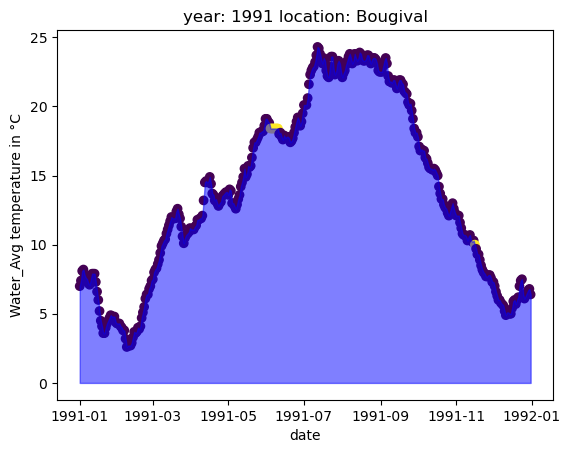

In [156]:
try: 
    year = next(year_iter)
    wiewer(year, location, main)
except StopIteration: 
    location = next(location_iter)
    year_iter = get_iter(location, main)    

Remove the above year from data if something is not right.

In [40]:
print(year, location)
#remove_year(year, main)

1991 Bougival


In [157]:
folder = "DataSets" 
main.to_csv(folder + "\WTA1_DataSet.csv", index=False)